In [1]:
from typing import Callable
from os import makedirs
from os.path import join
import numpy as np
import pandas as pd
from verma_net_radiation import verma_net_radiation_table
from PTJPL import process_PTJPL_table
from monte_carlo_sensitivity import perturbed_run, sensitivity_analysis, divide_absolute_by_unperturbed
import matplotlib.pyplot as plt
from scipy.stats import mstats
import seaborn as sns
from matplotlib.ticker import FuncFormatter

In [2]:
normalization_function = divide_absolute_by_unperturbed

In [3]:
input_df = pd.read_csv("calval_final_50_PTJPL_inputs.csv")
input_df = input_df[input_df.fAPARmax != 0]
input_df

,Unnamed: 0.1,tower,lat,lon,orbit,scene,tile,time_UTC,date_UTC,doy,...,VISdiff,NIRdiff,VISdir,NIRdir,SWout,LWin,LWout,hour_of_day,Topt,fAPARmax
0,0,US-Ha2,42.5393,-72.1779,9254,9,18TYN,2020-02-22 00:00:00,2020-02-22,53,...,0.000000,0.000000,0.000000,0.000000,0.000000,223.482510,310.837408,19,0.0,0.5545
1,1,US-Ha2,42.5393,-72.1779,10150,9,18TYN,2020-04-20 00:00:00,2020-04-20,111,...,0.000000,0.000000,0.000000,0.000000,0.000000,249.470817,483.042043,19,0.0,0.5545
2,2,US-Ha2,42.5393,-72.1779,10352,9,18TYN,2020-05-03 00:00:00,2020-05-03,124,...,0.000000,0.000000,0.000000,0.000000,0.000000,293.358154,368.124775,19,0.0,0.5545
3,3,US-Ha2,42.5393,-72.1779,10684,7,18TYN,2020-05-24 00:00:00,2020-05-24,145,...,3.627162,3.519072,0.337294,0.020315,0.662989,NaN,385.565499,19,0.0,0.5545
4,4,US-Ha2,42.5393,-72.1779,11069,8,18TYN,2020-06-18 00:00:00,2020-06-18,170,...,7.418505,8.696527,1.935220,0.123967,2.254700,380.029433,454.438012,19,0.0,0.5545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,247,US-xUK,39.0404,-95.1921,11909,6,15SUD,2020-08-11 00:00:00,2020-08-11,224,...,14.372975,12.682295,3.003822,0.000000,5.351180,414.848071,439.377199,17,5.8,0.4664
248,248,US-xUK,39.0404,-95.1921,16668,8,15SUD,2021-06-14 00:00:00,2021-06-14,165,...,32.456092,15.308895,93.412739,127.317082,27.991697,NaN,405.251251,17,5.8,0.4664
249,249,US-xUK,39.0404,-95.1921,16810,8,15SUD,2021-06-23 00:00:00,2021-06-23,174,...,38.645010,27.577193,80.881654,98.257540,28.021802,NaN,388.004691,17,5.8,0.4664
250,250,US-xUK,39.0404,-95.1921,16810,8,15SUD,2021-06-23 00:00:00,2021-06-23,174,...,38.645010,27.577193,80.881654,98.257540,28.021802,400.532814,463.095778,17,5.8,0.4664


In [4]:
np.nanmin(input_df.fAPARmax)

np.float64(0.3301)

In [5]:
def process_verma_PTJPL_table(input_df: pd.DataFrame) -> pd.DataFrame:
    return process_PTJPL_table(verma_net_radiation_table(input_df))

In [6]:
processed = process_verma_PTJPL_table(input_df)
processed

,Unnamed: 0.1,tower,lat,lon,orbit,scene,tile,time_UTC,date_UTC,doy,...,LWout,hour_of_day,Topt,fAPARmax,Rn_soil,LE_soil,Rn_canopy,LE_canopy,LE_interception,LE
0,0,US-Ha2,42.5393,-72.1779,9254,9,18TYN,2020-02-22 00:00:00,2020-02-22,53,...,310.837408,19,0.0,0.5545,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,US-Ha2,42.5393,-72.1779,10150,9,18TYN,2020-04-20 00:00:00,2020-04-20,111,...,483.042043,19,0.0,0.5545,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,US-Ha2,42.5393,-72.1779,10352,9,18TYN,2020-05-03 00:00:00,2020-05-03,124,...,368.124775,19,0.0,0.5545,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,3,US-Ha2,42.5393,-72.1779,10684,7,18TYN,2020-05-24 00:00:00,2020-05-24,145,...,385.565499,19,0.0,0.5545,NaN,NaN,NaN,NaN,NaN,NaN
4,4,US-Ha2,42.5393,-72.1779,11069,8,18TYN,2020-06-18 00:00:00,2020-06-18,170,...,454.438012,19,0.0,0.5545,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,247,US-xUK,39.0404,-95.1921,11909,6,15SUD,2020-08-11 00:00:00,2020-08-11,224,...,439.377199,17,5.8,0.4664,0.668879,0.289100,2.308688,1.455829,0.533916,2.278845
248,248,US-xUK,39.0404,-95.1921,16668,8,15SUD,2021-06-14 00:00:00,2021-06-14,165,...,405.251251,17,5.8,0.4664,NaN,NaN,NaN,NaN,NaN,NaN
249,249,US-xUK,39.0404,-95.1921,16810,8,15SUD,2021-06-23 00:00:00,2021-06-23,174,...,388.004691,17,5.8,0.4664,NaN,NaN,NaN,NaN,NaN,NaN
250,250,US-xUK,39.0404,-95.1921,16810,8,15SUD,2021-06-23 00:00:00,2021-06-23,174,...,463.095778,17,5.8,0.4664,21.707614,5.350985,147.817534,103.070964,16.937392,125.359341


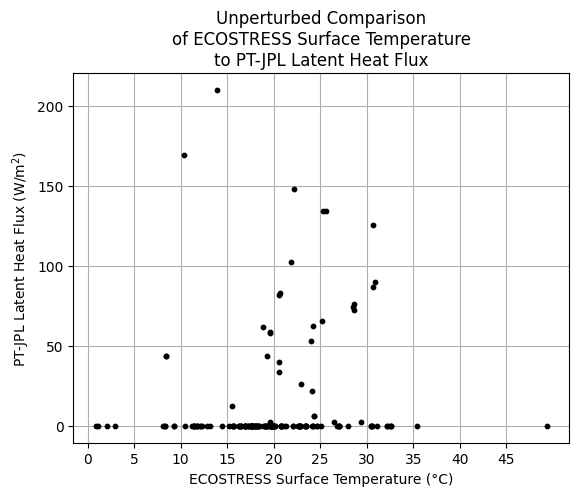

In [7]:
plt.xticks(range(int(min(processed.ST_C)), int(max(processed.ST_C)) + 1, 5))
plt.scatter(x=processed.ST_C, y=processed.LE, color='black', s=10, zorder=5)
plt.grid(True, zorder=0)
plt.xlabel("ECOSTRESS Surface Temperature (°C)")
plt.ylabel("PT-JPL Latent Heat Flux (W/m$^2$)")
plt.title("Unperturbed Comparison\nof ECOSTRESS Surface Temperature\nto PT-JPL Latent Heat Flux")

plt.savefig("Unperturbed Comparison of ECOSTRESS Surface Temperature to PT-JPL Latent Heat Flux.jpeg", format='jpeg', bbox_inches='tight')
plt.savefig("Unperturbed Comparison of ECOSTRESS Surface Temperature to PT-JPL Latent Heat Flux.svg", format='svg', bbox_inches='tight')

plt.show()

In [8]:
input_df = pd.read_csv("calval_final_50_PTJPL_inputs.csv")

if "Ta" in input_df and "Ta_C" not in input_df:
    # input_df.rename({"Ta": "Ta_C"}, inplace=True)
    input_df["Ta_C"] = input_df["Ta"]

input_df = input_df[input_df.fAPARmax.apply(lambda fAPARmax: fAPARmax > 0.001)]
input_df = input_df[input_df.NDVI.apply(lambda NDVI: NDVI > 0.05)]

np.nanmin(input_df.ST_C), np.nanmax(input_df.ST_C)

(np.float64(0.89), np.float64(49.33))

In [9]:
input_variable = "ST_C"
output_variable = "LE"

results = perturbed_run(
    input_df=input_df, 
    input_variable=input_variable, 
    output_variable=output_variable, 
    forward_process=process_verma_PTJPL_table,
    normalization_function=normalization_function
)

results

TypeError: loop of ufunc does not support argument 0 of type float which has no callable sqrt method

In [ ]:
filtered_results = results.dropna()
filtered_results

In [ ]:
# plt.scatter(filtered_results.input_perturbation, filtered_results.output_perturbation)

In [ ]:
# plt.xticks(range(int(min(processed.ST_C)), int(max(processed.ST_C)) + 1, 5))
# plt.ylim(-350, 150)
plt.scatter(x=results.input_perturbation, y=results.output_perturbation, color='black', s=10, zorder=5)  # Adjust the 's' parameter to make dots thinner
plt.grid(True, zorder=0)
plt.xlabel("Change in Surface Temperature (°C)")
plt.ylabel("Change in PT-JPL Latent Heat Flux (W/m$^2$)")
plt.title("Comparison of Change\nin Surface Temperature\nto PT-JPL Latent Heat Flux")

plt.savefig("Comparison of Change in Surface Temperature to PT-JPL Latent Heat Flux.jpeg", format='jpeg', bbox_inches='tight')
plt.savefig("Comparison of Change in Surface Temperature to PT-JPL Latent Heat Flux.svg", format='svg', bbox_inches='tight')

plt.show()

In [ ]:
correlation = mstats.pearsonr(
    np.array(filtered_results.input_perturbation_std).astype(np.float64), 
    np.array(filtered_results.output_perturbation_std).astype(np.float64)
)[0]

correlation

In [ ]:
input_variables = ["ST_C", "NDVI", "albedo", "Ta_C", "RH"]
output_variables = ["LE"]

perturbation_df, sensitivity_metrics_df = sensitivity_analysis(
    input_df=input_df,
    input_variables=input_variables,
    output_variables=output_variables,
    forward_process=process_verma_PTJPL_table,
    normalization_function=normalization_function
)

sensitivity_metrics_df

In [ ]:
df = sensitivity_metrics_df
df = df[(df.output_variable == "LE") & (df.metric == "mean_normalized_change")]
ax = sns.barplot(x=df.input_variable, y=df.value * 100, color='black')
ax.set_xticklabels(["Surface\nTemperature", "NDVI", "Albedo", "Air\nTemperature", "Relative\nHumidity"])
plt.xlabel("Input Variable")
plt.ylabel("Average Percent Change in Output Perturbation")
plt.title("PT-JPL Latent Heat Flux Sensitivity Magnitude")
# plt.ylim(0, 160)  # Set y-axis range from 0 to 160
plt.grid(axis='y', color='lightgray', linestyle='-', linewidth=0.5)  # Add light gray horizontal gridlines only

# Add percent sign to y-axis tick labels
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y)}%'))

plt.savefig("PT-JPL Latent Heat Flux Sensitivity Magnitude.jpeg", format='jpeg', bbox_inches='tight')
plt.savefig("PT-JPL Latent Heat Flux Sensitivity Magnitude.svg", format='svg', bbox_inches='tight')

plt.show()

In [ ]:
df = sensitivity_metrics_df
df = df[(df.output_variable == "LE") & (df.metric == "correlation")]
ax = sns.barplot(x=df.input_variable, y=df.value, color='black')
ax.set_xticklabels(["Surface\nTemperature", "NDVI", "Albedo", "Air\nTemperature", "Relative\nHumidity"])
# plt.ylim(0, 0.8)
plt.xlabel("Input Variable")
plt.ylabel("Correlation of Input Perturbation to Output Perturbation")
plt.title("PT-JPL Latent Heat Flux Sensitivity Correlation")
plt.grid(axis='y')  # Add horizontal gridlines

plt.savefig("PT-JPL Latent Heat Flux Sensitivity Correlation.jpeg", format='jpeg', bbox_inches='tight')
plt.savefig("PT-JPL Latent Heat Flux Sensitivity Correlation.svg", format='svg', bbox_inches='tight')

plt.show()